<a href="https://colab.research.google.com/github/OtolaHan/Otola_Han_KAAN/blob/main/utitls3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install fedot

In [1]:
!pip install fedot[extra]

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

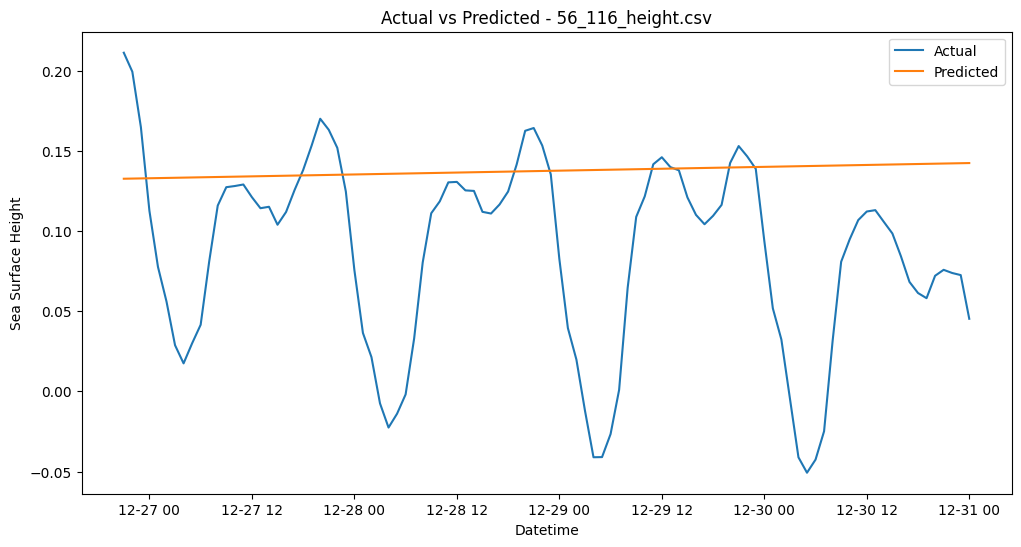

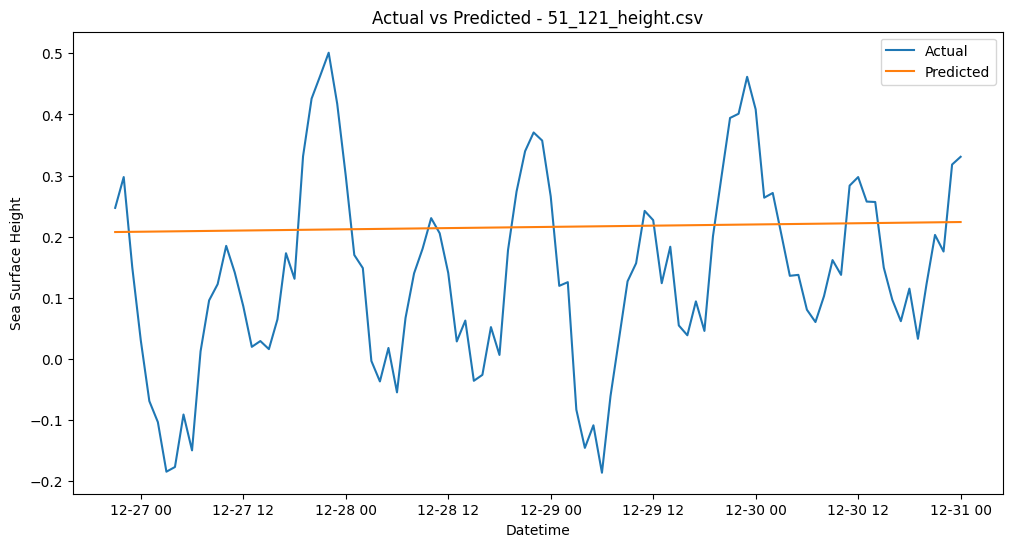

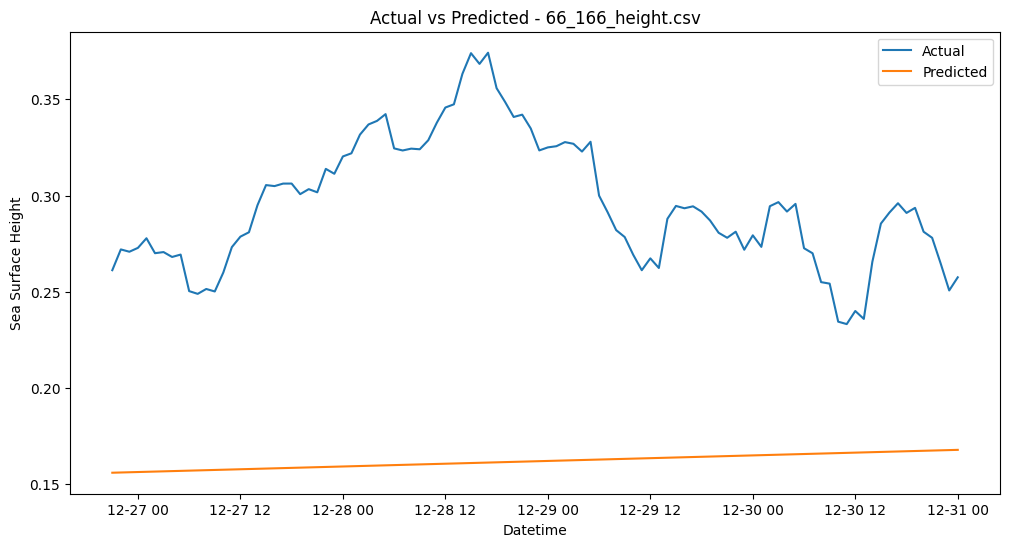

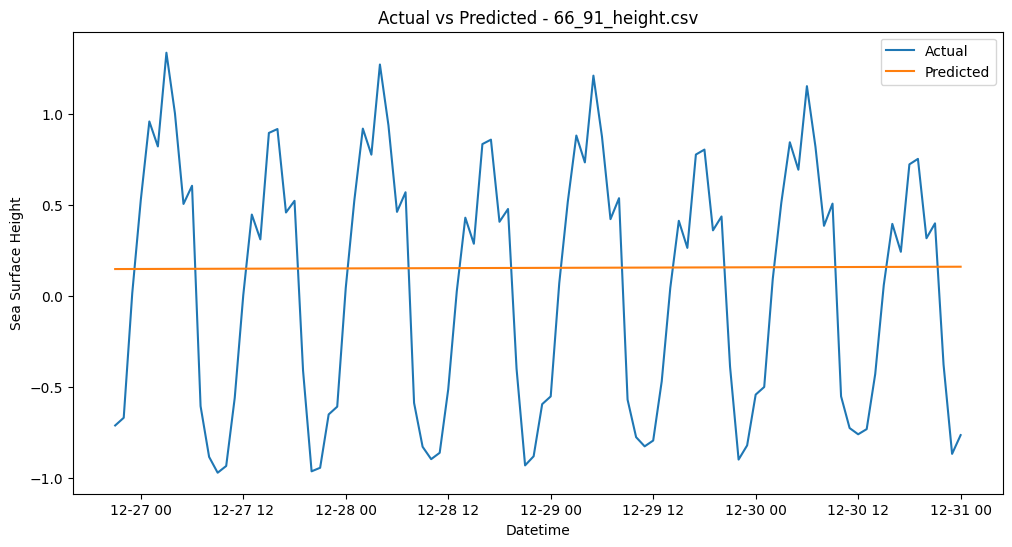

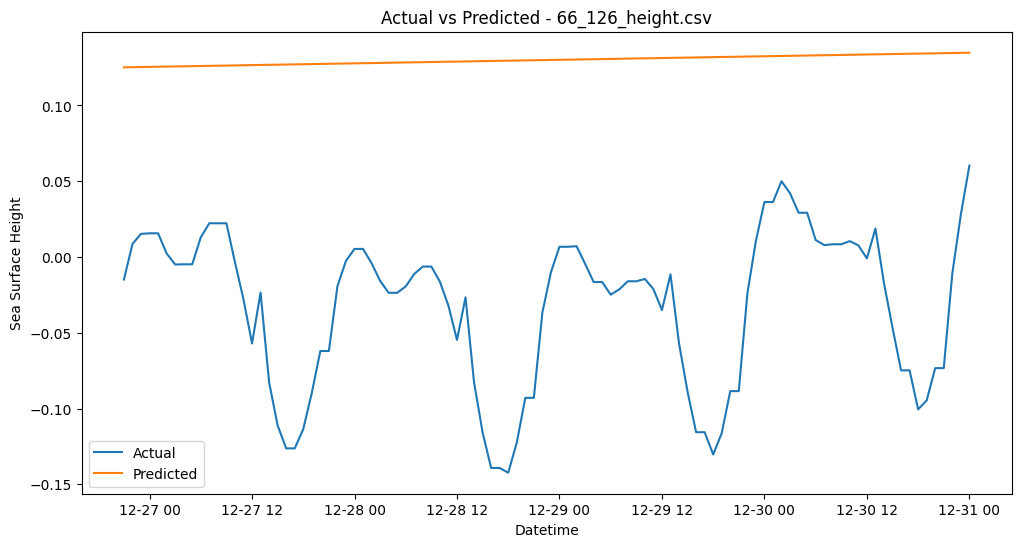

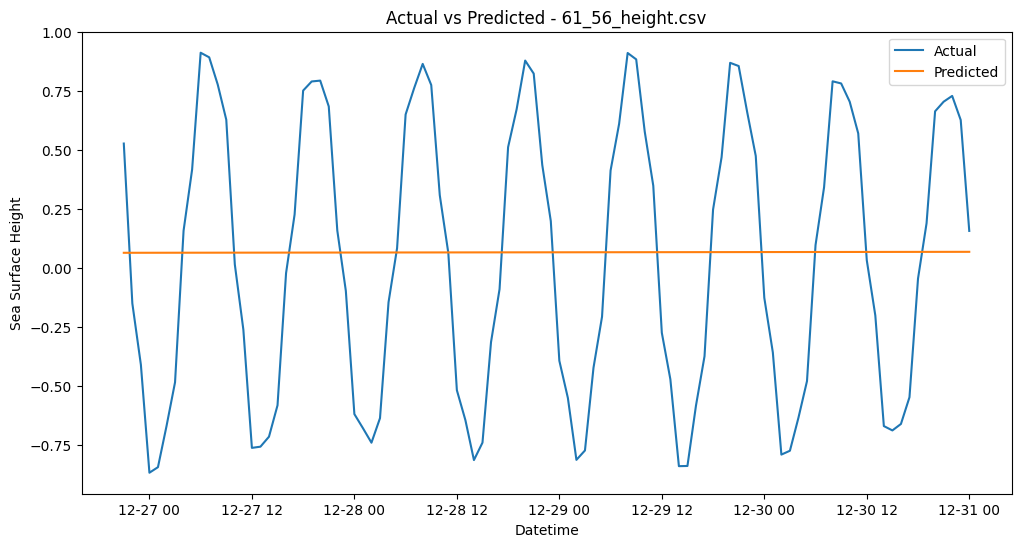

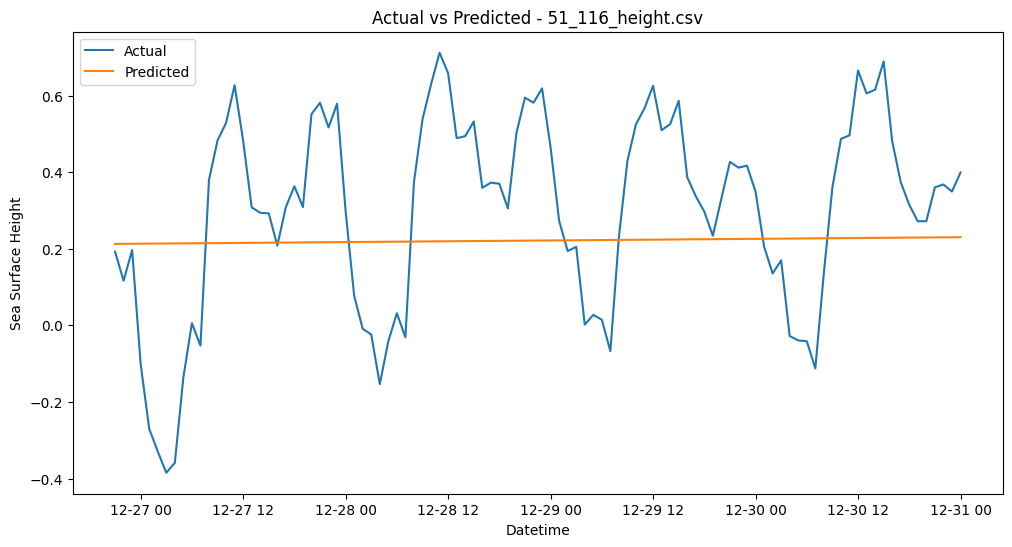

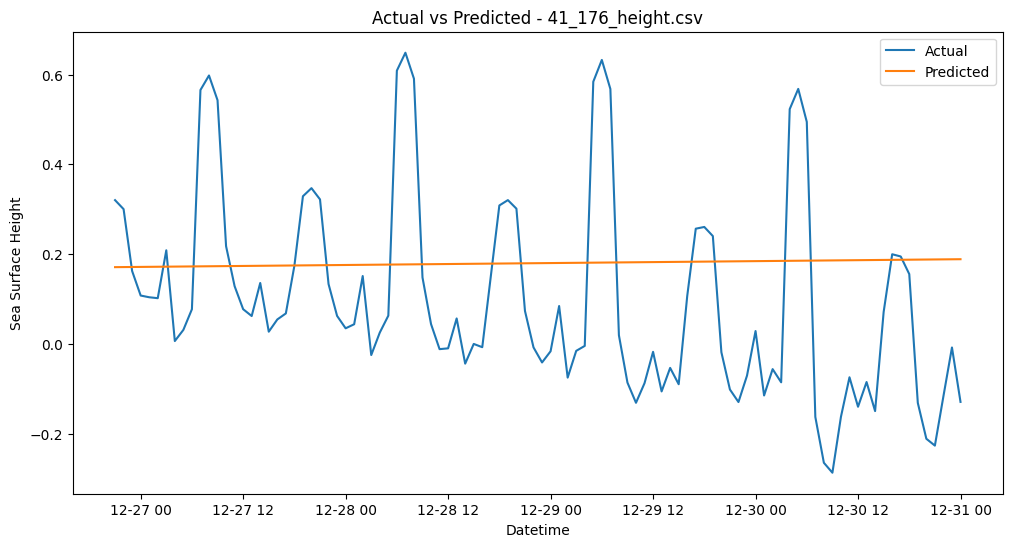

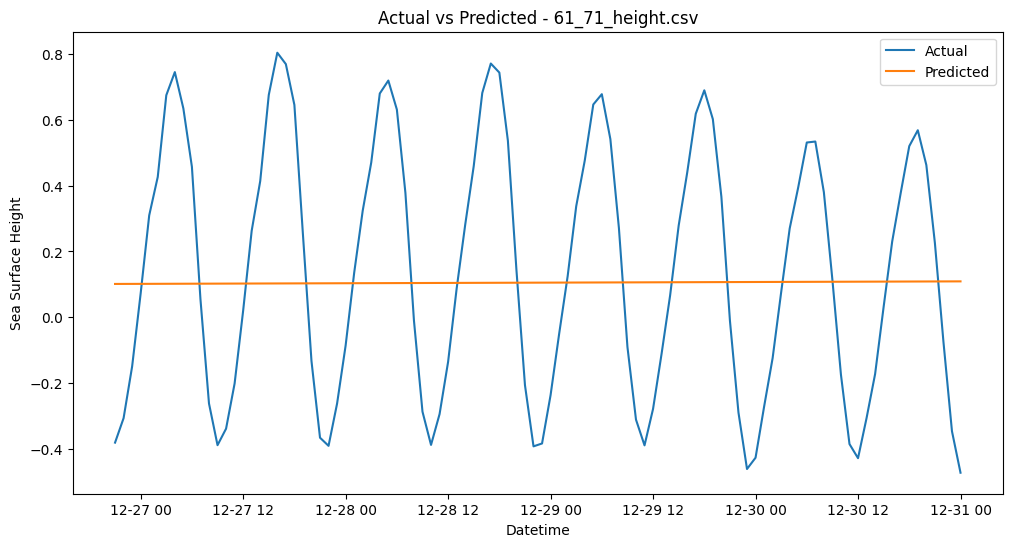

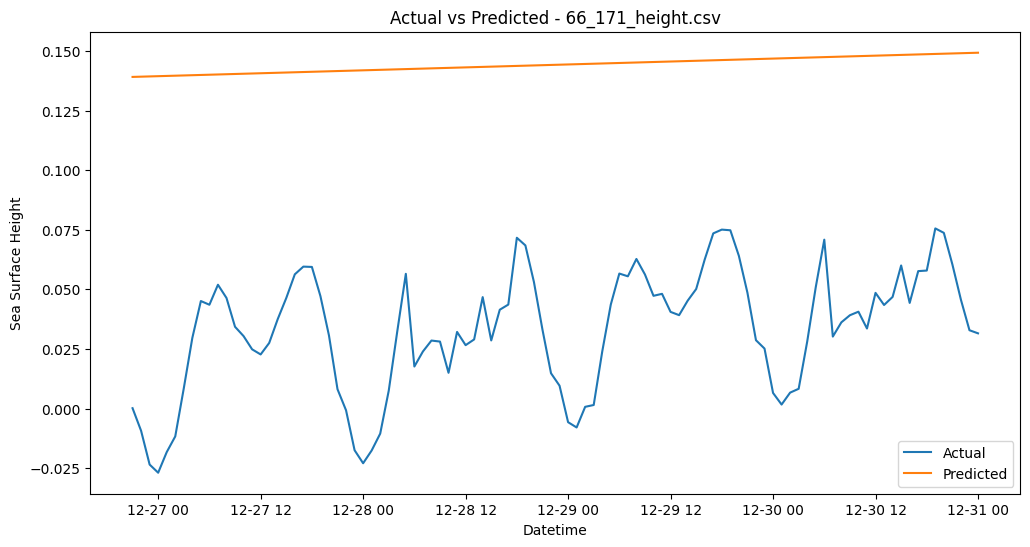

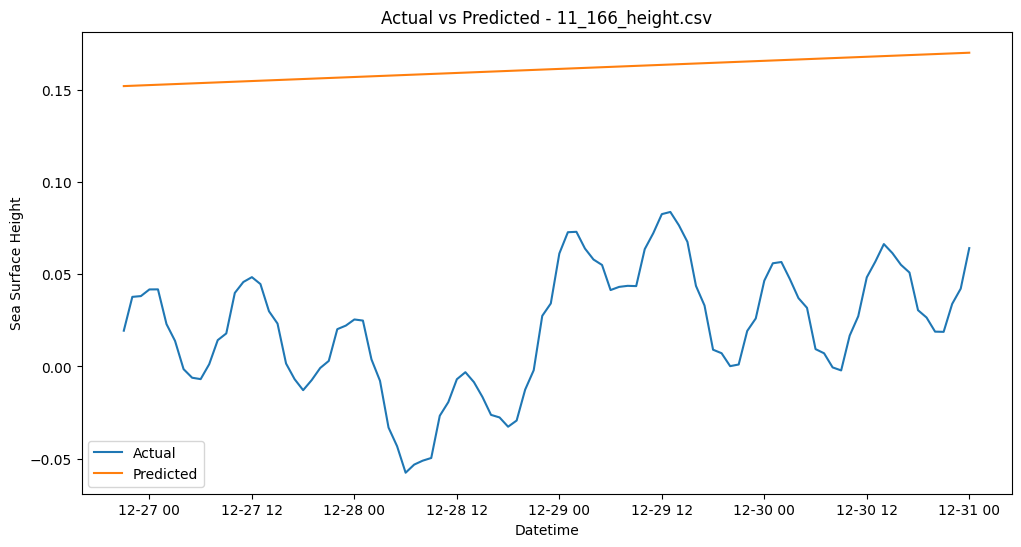

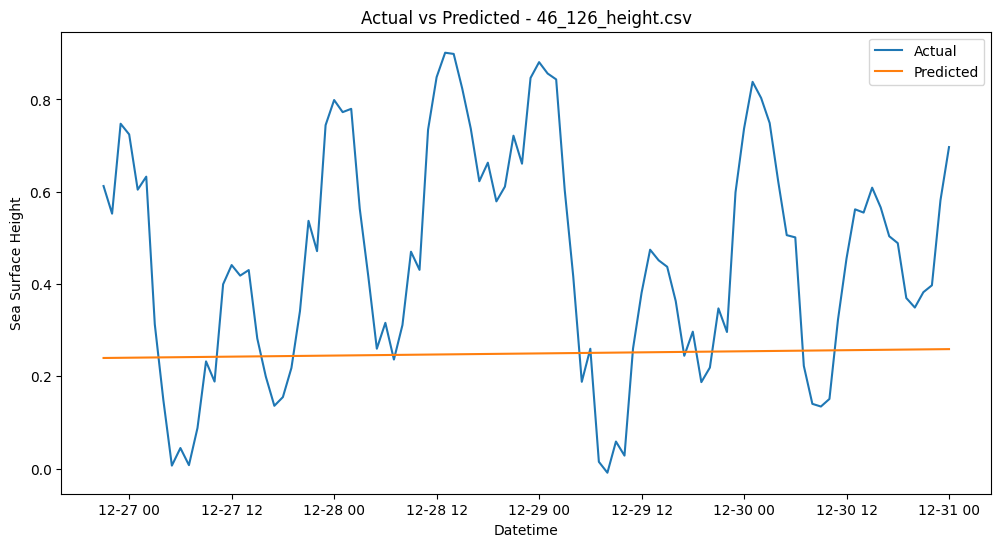

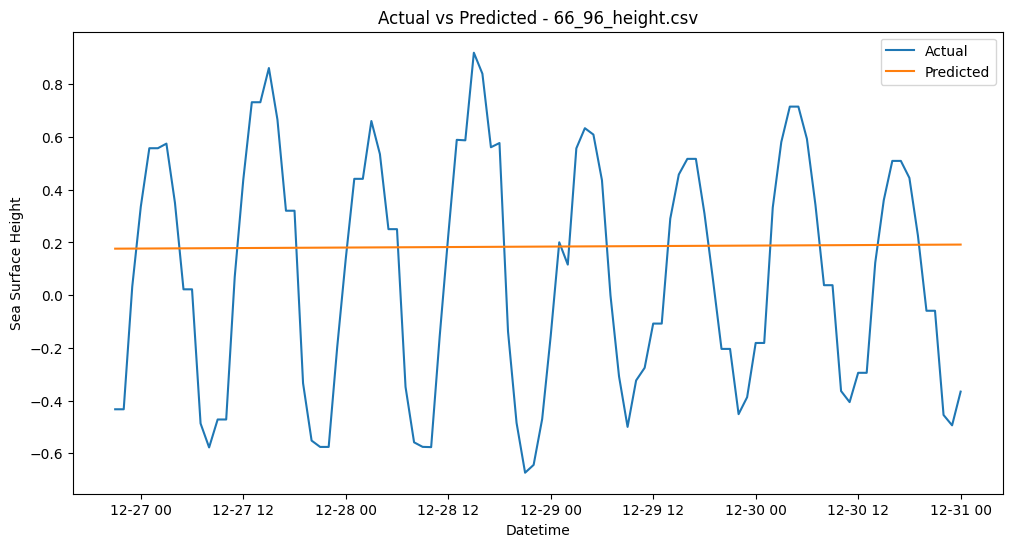

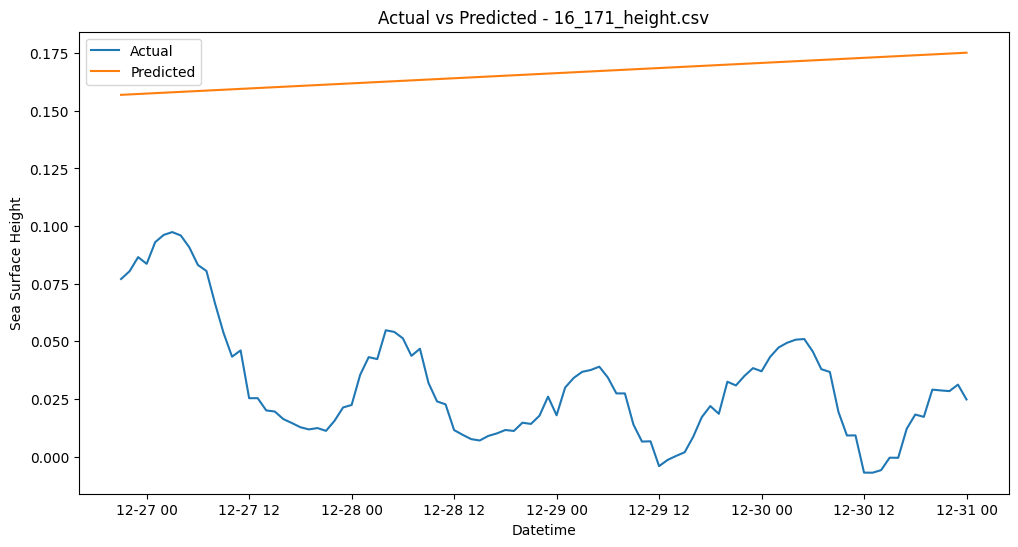

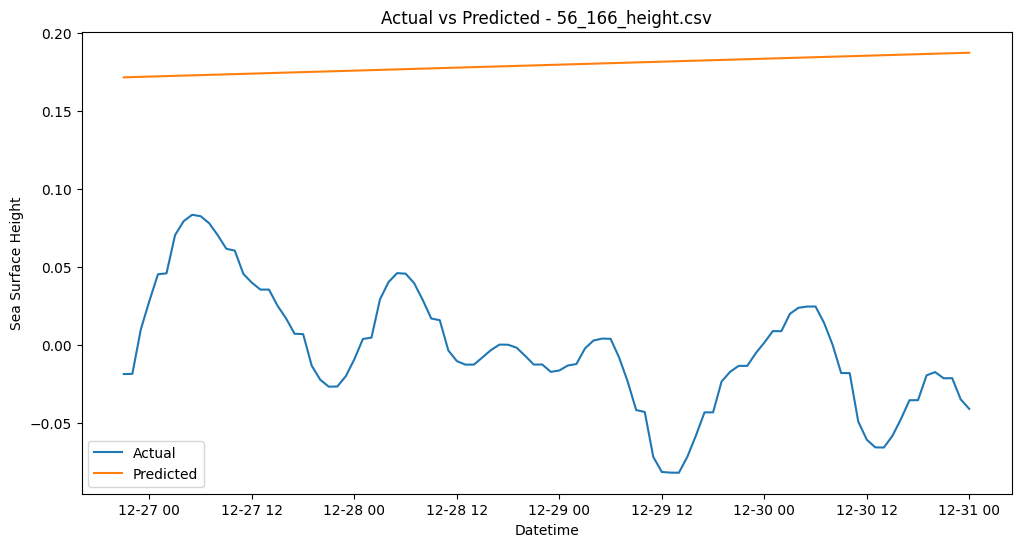

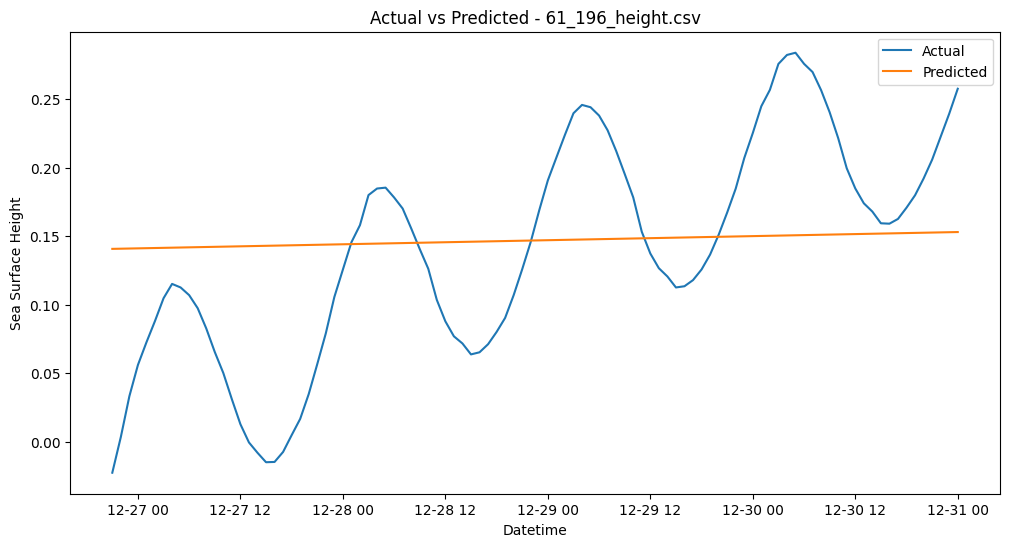

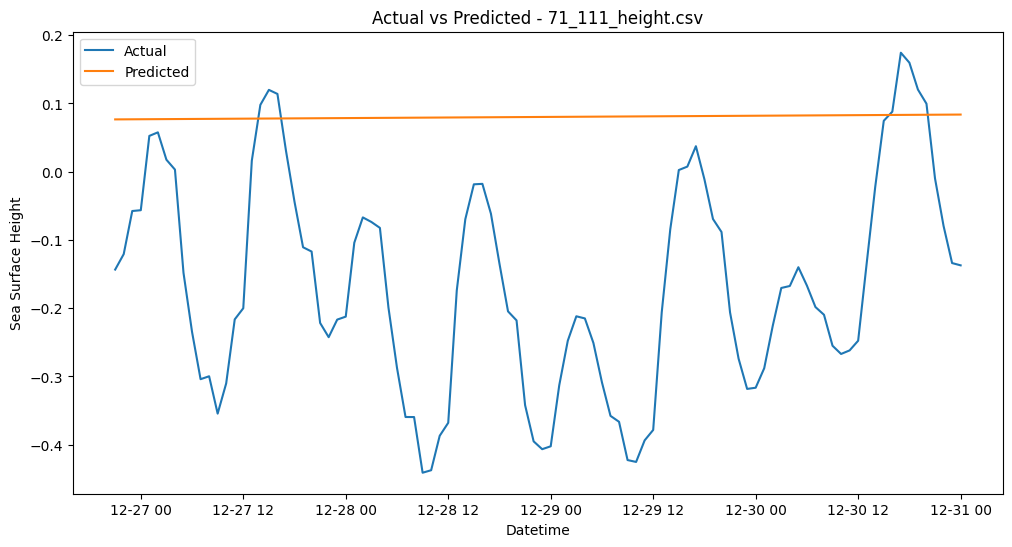

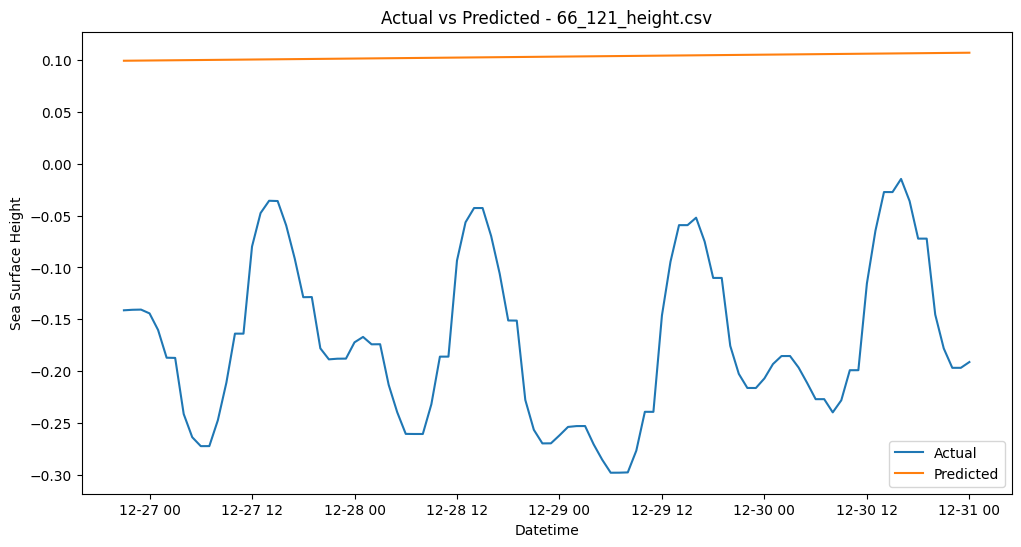

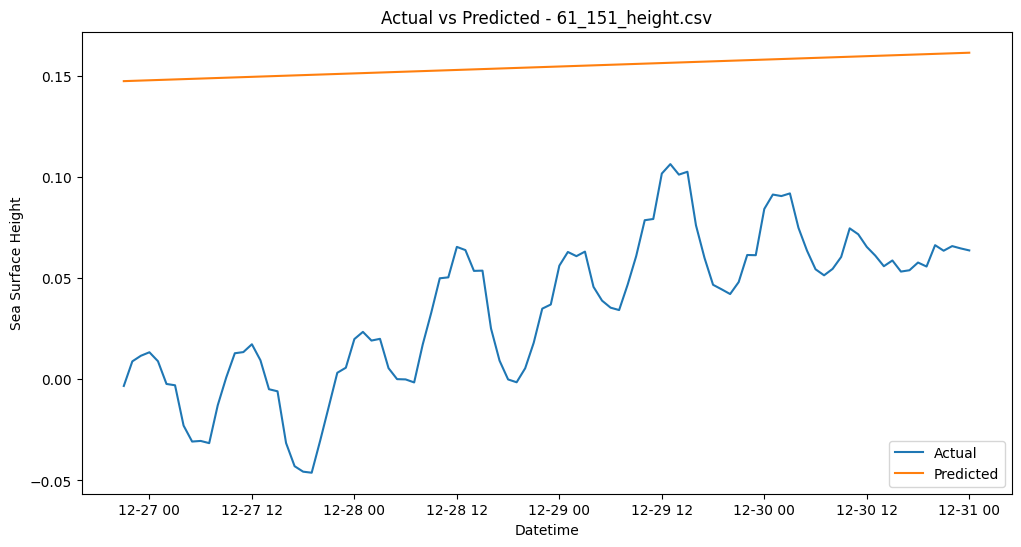

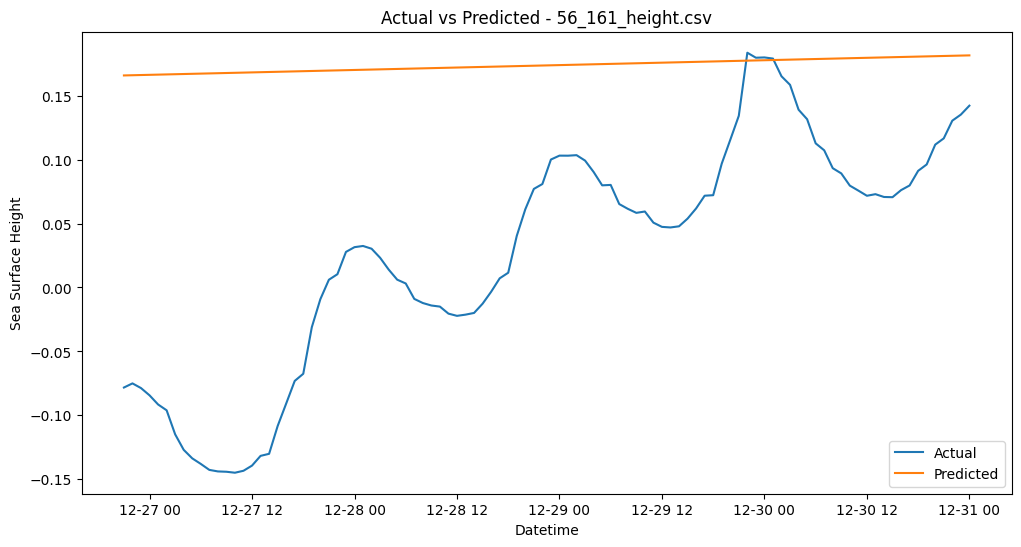

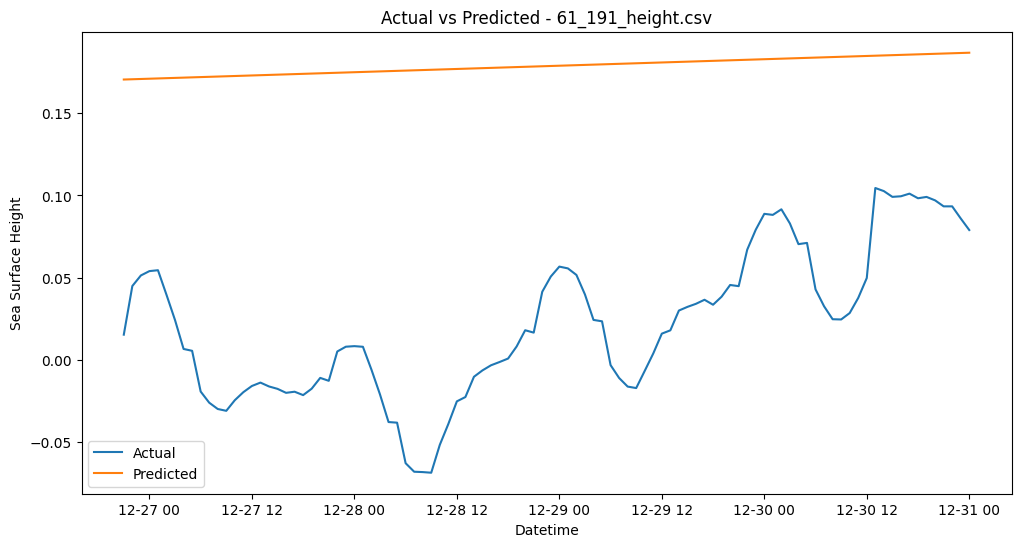

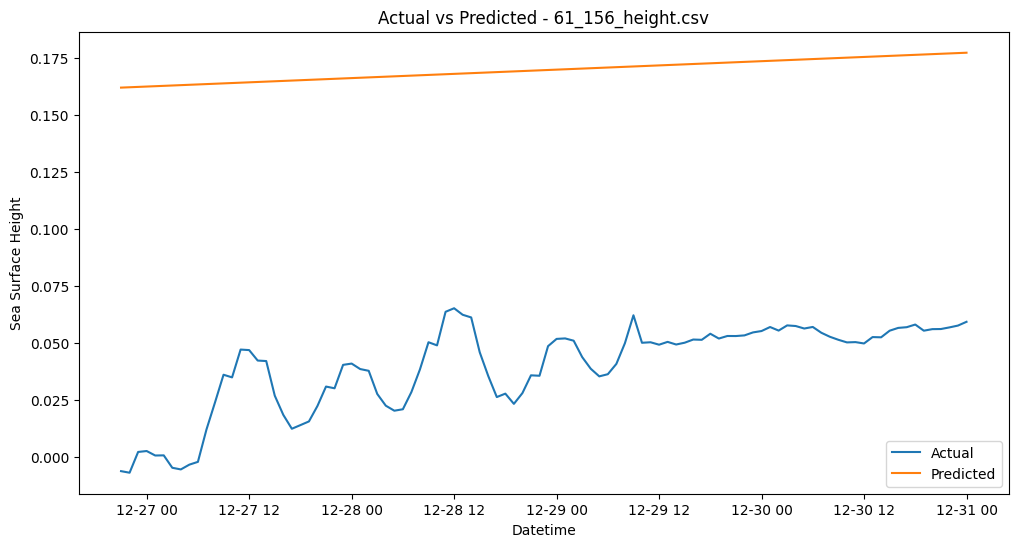

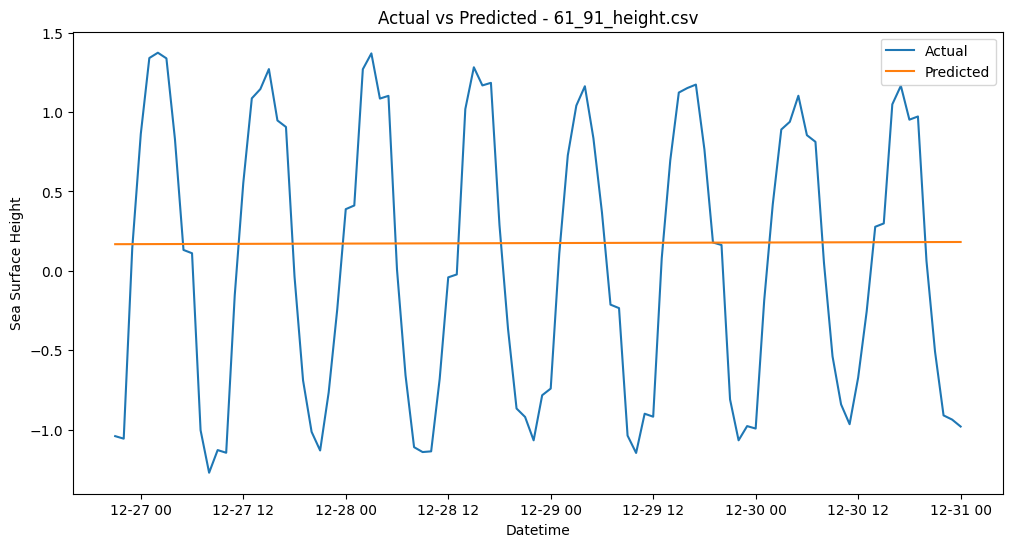

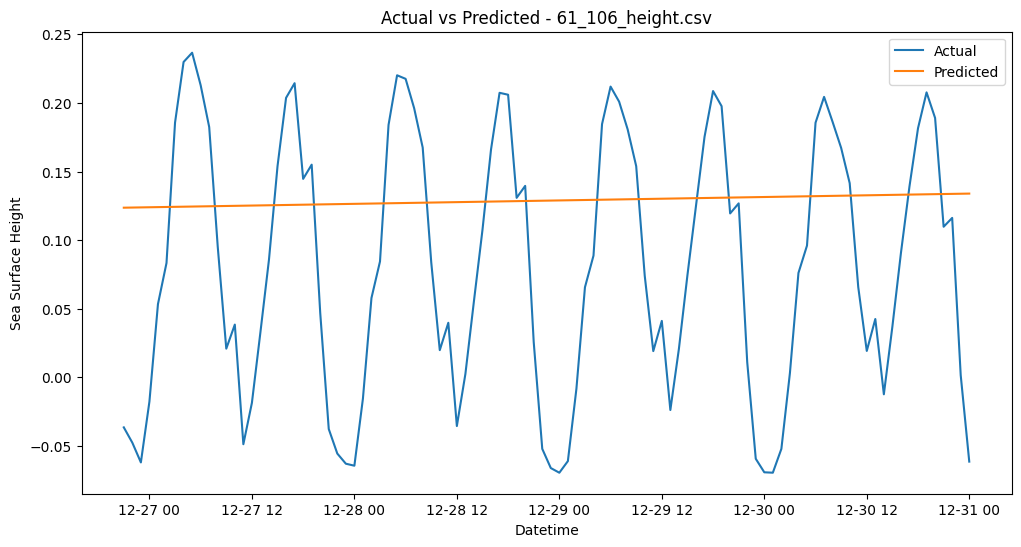

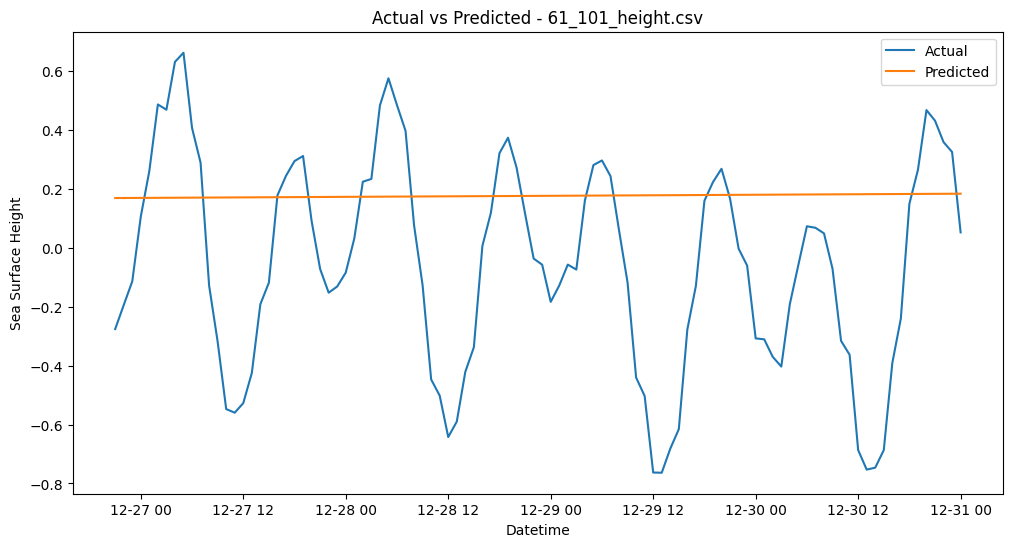

Evaluation Results:
                 File       SMAPE       MSE
0   56_116_height.csv   62.932740  0.006213
1   51_121_height.csv   85.081931  0.029270
2   66_166_height.csv   57.674013  0.019003
3    66_91_height.csv  148.517696  0.470281
4   66_126_height.csv  185.801147  0.028689
5    61_56_height.csv  169.625454  0.355289
6   51_116_height.csv   87.981219  0.070604
7   41_176_height.csv  125.108133  0.056513
8    61_71_height.csv  146.989399  0.152623
9   66_171_height.csv  127.831510  0.012961
10  11_166_height.csv  148.808449  0.020479
11  46_126_height.csv   70.156767  0.102616
12   66_96_height.csv  137.562117  0.207710
13  16_171_height.csv  140.767304  0.018990
14  56_166_height.csv  176.005359  0.034857
15  61_196_height.csv   52.730153  0.005865
16  71_111_height.csv  177.320577  0.084512
17  66_121_height.csv  200.000000  0.081127
18  61_151_height.csv  128.847140  0.015376
19  56_161_height.csv  122.361483  0.028757
20  61_191_height.csv  150.230887  0.026329
21  61_156_h

In [23]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from utils import create_folder, smape
import matplotlib.pyplot as plt


def load_data(file_path):
    return pd.read_csv(file_path, parse_dates=['datetime'], index_col='datetime')


def train_model(data):
    X = data[:-100].index.astype(int).values.reshape(-1, 1)
    y = data['ssh'][:-100].values
    model = LinearRegression()
    model.fit(X, y)
    return model


def generate_predictions(model, start_time, num_predictions):
    prediction_times = pd.date_range(start=start_time, periods=num_predictions, freq='H')
    X_pred = prediction_times.astype(int).values.reshape(-1, 1)
    predictions = model.predict(X_pred)
    return pd.DataFrame({'ssh': predictions}, index=prediction_times)


def save_predictions(predictions, file_name, save_folder):
    predictions.reset_index().rename(columns={'index': 'datetime'}).to_csv(os.path.join(save_folder, file_name),
                                                                           index=False)


def evaluate_model(data, predictions):
    y_true = data['ssh'][-100:].values
    y_pred = predictions['ssh'].values
    smape_score = smape(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return smape_score, mse


def plot_results(data, predictions, file_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['ssh'], label='Actual')
    plt.plot(predictions.index, predictions['ssh'], label='Predicted')
    plt.xlabel('Datetime')
    plt.ylabel('Sea Surface Height')
    plt.title(f'Actual vs Predicted - {file_name}')
    plt.legend()
    plt.show()


def main():
    train_folder = "train"
    baseline_folder = "baseline"
    predictions_folder = "predictions"
    create_folder(predictions_folder)

    results = []

    for file_name in os.listdir(train_folder):
        train_file_path = os.path.join(train_folder, file_name)
        baseline_file_path = os.path.join(baseline_folder, "baseline_forecasts", file_name)

        train_data = load_data(train_file_path)
        baseline_data = load_data(baseline_file_path)

        model = train_model(train_data)

        start_time = '2002-12-26 21:00:00'
        num_predictions = 100
        predictions = generate_predictions(model, start_time, num_predictions)

        save_predictions(predictions, file_name, predictions_folder)

        smape_score, mse = evaluate_model(baseline_data, predictions)
        results.append((file_name, smape_score, mse))

        plot_results(baseline_data, predictions, file_name)

    results_df = pd.DataFrame(results, columns=['File', 'SMAPE', 'MSE'])
    print("Evaluation Results:")
    print(results_df)


if __name__ == "__main__":
    main()